## Data inspection and quality

Check noise, integrated flux and spectra of cubes with different binning


In [3]:
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon
from matplotlib.path import Path

import seaborn as sns
sns.set(style="whitegrid")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from scipy.ndimage import filters

from reproject import reproject_interp

from astropy.io import fits
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS

## AS1063

All cubes available

    Native binning
    N: ../Data/Cubes/AS1063_CO_4-3_pbcor_10kms.fits
    
    Rebined
    R1: ../Data/Cubes/AS1063_A_a_07_TM1_CO_4-3.image.pbcor.fits
    R2: ../Data/Cubes/latest_cubes/AS1063_CO_4-3_pbcor_rebin.fits


Check the channel width

In [10]:
from astropy.constants import c

def channel_width(file):
    wcs = fits.getheader(file)
    print(-wcs['CDELT3']/wcs['CRVAL3']* c.to('km/s'))
    return (-wcs['CDELT3']/wcs['CRVAL3']* c.to('km/s')).value


file_N = '../Data/Cubes/all_cubes/AS1063_CO_4-3_pbcor_10kms.fits'
file_R1 = '../Data/Cubes/AS1063_A_a_07_TM1_CO_4-3.image.pbcor.fits'
file_R2 = '../Data/Cubes/all_cubes/latest_cubes/AS1063_CO_4-3_pbcor_rebin.fits'

ch_N_as1063 = channel_width(file_N)
ch_R1_as1063 = channel_width(file_R1)
ch_R2_as1063 = channel_width(file_R2)

8.157834918794387 km / s
29.940078389057593 km / s
24.47350475638525 km / s


check data

<IPython.core.display.Javascript object>


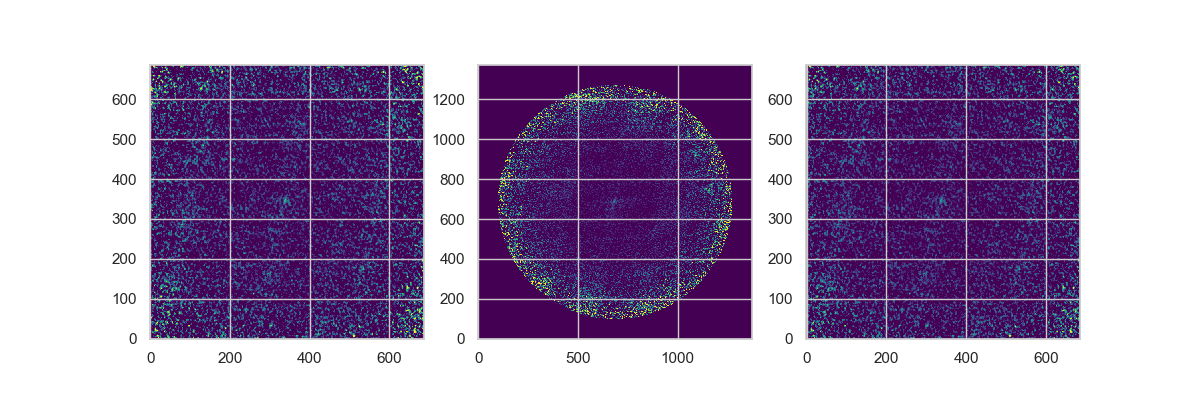

In [11]:
def make_image(file,channel=False):
    data = fits.getdata(file)
    data = np.squeeze(data)
    if channel:
        data = data[channel['start']:channel['end']:,:]
    im = np.nansum(data,axis=0)
    return im

N_as1063_im = make_image(file_N)

R1_as1063_im = make_image(file_R1)
R2_as1063_im = make_image(file_R2)

fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(N_as1063_im,cmap='viridis',origin='lower',vmax=0.05,vmin=0)
ax[1].imshow(R1_as1063_im,cmap='viridis',origin='lower',vmax=0.02,vmin=0)
ax[2].imshow(R2_as1063_im,cmap='viridis',origin='lower',vmax=0.02,vmin=0)

Integrated flux / Integrated spectrum

<IPython.core.display.Javascript object>


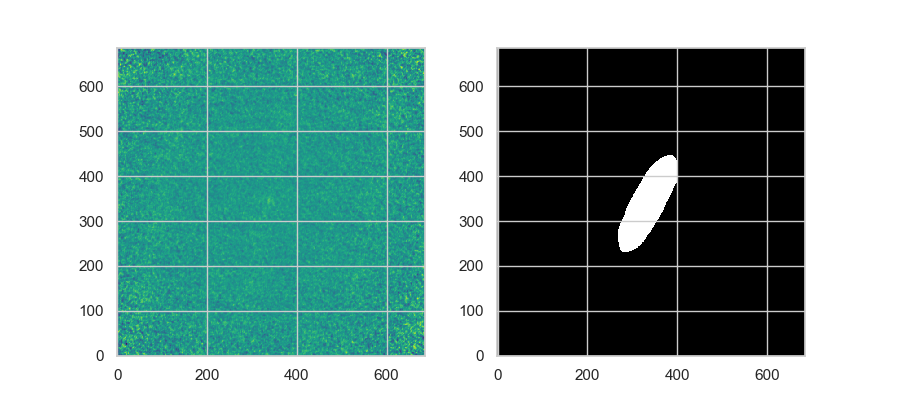

<IPython.core.display.Javascript object>


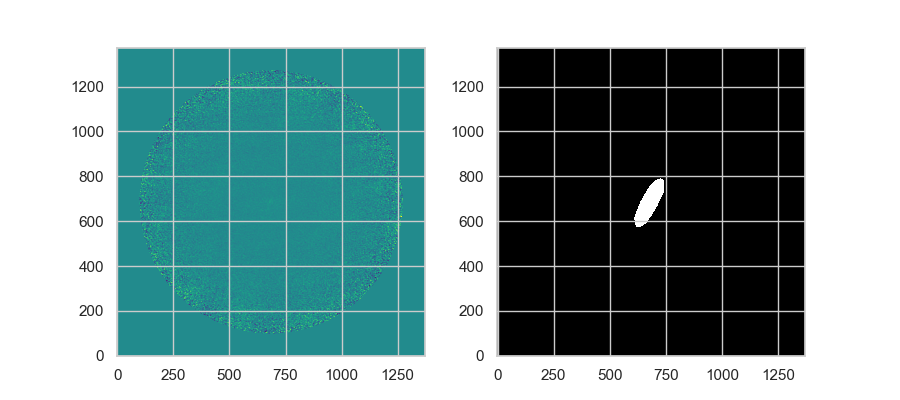

In [12]:
def load_hst(header):
    h = fits.getheader(header)
    mask,_ = reproject_interp('as1063_target_mask.fits',h)
    mask = mask.astype('float')
    mask[np.where(np.isnan(mask))] = 0
    return mask

mask1_as1063 = load_hst('../Data/Moments/AS1063_CO_4-3_pbcor_10kms_mom0.fits')

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(N_as1063_im,origin='lower',cmap='viridis')
ax[1].imshow(mask1_as1063,origin='lower',vmax=0.1,cmap='Greys_r')


mask2_as1063 = load_hst('../Data/Moments/as1063_mom0.fits')
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(R1_as1063_im,origin='lower',cmap='viridis')
ax[1].imshow(mask2_as1063,origin='lower',vmax=0.1,cmap='Greys_r')

<IPython.core.display.Javascript object>


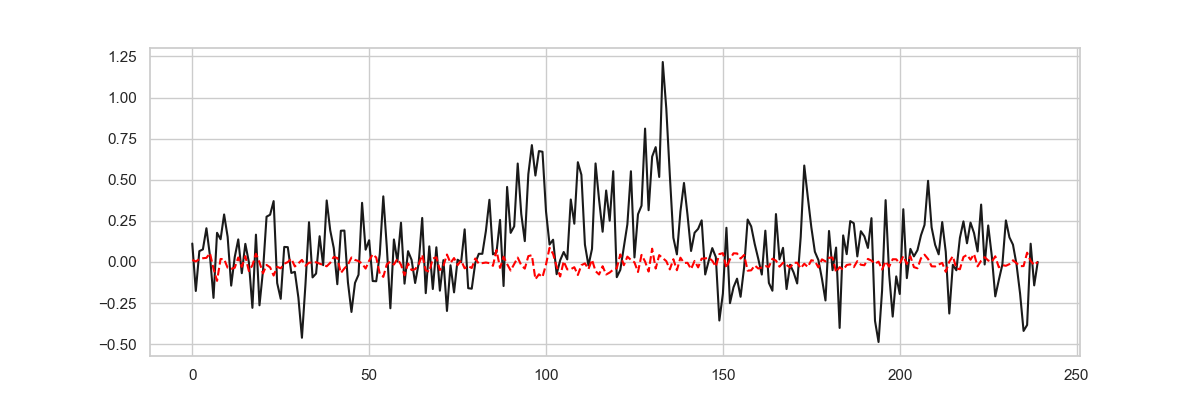

<IPython.core.display.Javascript object>


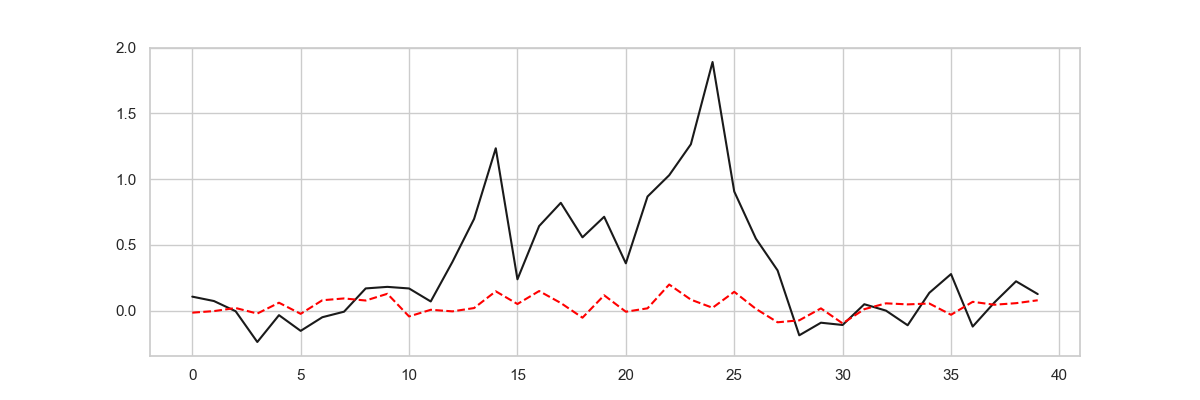

<IPython.core.display.Javascript object>


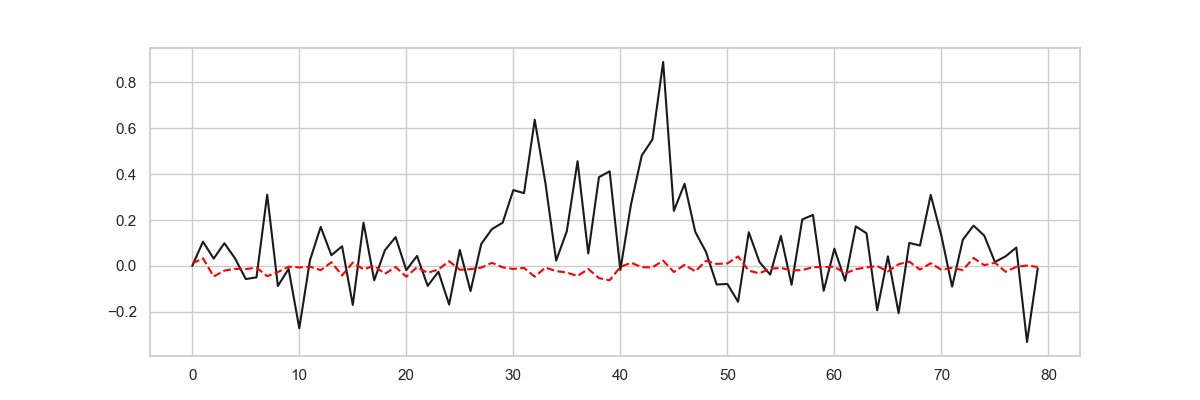

In [14]:
def extract_spectrum(file,mask):
    data = fits.getdata(file)
    data = np.squeeze(data)
    data_target = data*mask
    data_noise = data*(1-mask)
    sp = np.nansum(data_target,axis=(1,2))
    noise = np.nanmean(data_noise,axis=(1,2))*len(np.where(mask==1)[0])
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    ax.plot(sp,color='k')
    ax.plot(noise,color='red',linestyle='--')
    
    return sp

sp_N_as1063  = extract_spectrum(file_N,mask1_as1063 )

sp_R1_as1063   = extract_spectrum(file_R1,mask2_as1063 )
sp_R2_as1063   = extract_spectrum(file_R2,mask1_as1063 )

In [32]:
def save_spectra(name,spec,cube):
    header_cube = fits.getheader(cube)
    sp_header = WCS(naxis=1).to_header()
    sp_header['CTYPE'] = header_cube['CTYPE3']
    sp_header['CRPIX1'] = header_cube['CRPIX3']
    sp_header['CDELT1'] = header_cube['CDELT3']
    sp_header['CRVAL1'] = header_cube['CRVAL3']
    fits.writeto('../Data/Spectra/'+name,spec,sp_header,overwrite=True)

save_spectra('as1063_spec_CO_4-3_pbcor_10kms.fits',sp_N_as1063,file_N)

save_spectra('as1063_A_a_07_TM1_CO_4-3.image.pbcor.fits',sp_R1_as1063,file_R1)

Make 'narrow bands'

In [61]:
N_as1063_im = make_image('../Data/Cubes/AS1063_CO_4-3_pbcor_10kms.fits',{'start':70,'end':150})

R1_as1063_im = make_image('../Data/Cubes/AS1063_A_a_07_TM1_CO_4-3.image.pbcor.fits',{'start':10,'end':30})
R2_as1063_im = make_image('../Data/Cubes/latest_cubes/AS1063_CO_4-3_pbcor_rebin.fits',{'start':25,'end':50})

measure flux

    in spectra
    in 'narrow band'

In [131]:
def integrate_spectra(sp, start,end,ch_width,file,std=None):
    if std is None:
        noise_sp = [item for sublist in [sp[:start],sp[end:]] for item in sublist]
        mean,_,std = sigma_clipped_stats(noise_sp)
    flux = np.nansum(sp[start:end])*ch_width
    print('Flux %0.4f (Jy/beam)'%flux)
    
    # Transform from Jy/beam to Jy: https://github.com/dendrograms/astrodendro/blob/stable/astrodendro/flux.py (line 106)
    ## beams_per_pixel = spatial_scale ** 2 / (beam_minor * beam_major * 1.1331) * u.beam
    ## q = (input_quantities * beams_per_pixel).to(u.Jy)
    header = fits.getheader(file)
    spatial_scale = header['CDELT2'] # pixel size
    beams_per_pixel = spatial_scale ** 2 / (header['BMAJ']*header['BMIN']* 1.1331)
    print('Flux %0.4f (Jy)'%(flux*beams_per_pixel))
    
    ## Estimate noise by multipliing the std by the number of pixels
    flux_noise = std * (end-start)
    print('Error %0.4f (Jy)'%(flux_noise*beams_per_pixel))


def integrate_narrow_band(nb,mask,ch_width):
    noise_im = nb*(1-mask)
    mean,_,std = sigma_clipped_stats(noise_im)
    print(mean,std)
    print('Flux %0.4f'%np.nansum(nb*mask)*ch_width)


integrate_spectra(sp_N_as1063,70,150,ch_N_as1063,'../Data/Cubes/AS1063_CO_4-3_pbcor_10kms.fits')
integrate_spectra(sp_N_as1063,0,-1,ch_N_as1063,'../Data/Cubes/AS1063_CO_4-3_pbcor_10kms.fits')

print('\n')
integrate_spectra(sp_R1_as1063,10,30,ch_R1_as1063,'../Data/Cubes/AS1063_A_a_07_TM1_CO_4-3.image.pbcor.fits')
integrate_spectra(sp_R1_as1063,0,-1,ch_R1_as1063,'../Data/Cubes/AS1063_A_a_07_TM1_CO_4-3.image.pbcor.fits')

print('\n')
integrate_spectra(sp_R2_as1063,25,50,ch_R2_as1063,'../Data/Cubes/latest_cubes/AS1063_CO_4-3_pbcor_rebin.fits')
integrate_spectra(sp_R2_as1063,0,-1,ch_R2_as1063,'../Data/Cubes/latest_cubes/AS1063_CO_4-3_pbcor_rebin.fits')

Flux 152.0538 (Jy/beam)
Flux 6.0852 (Jy)
Error 0.6324 (Jy)
Flux 189.6862 (Jy/beam)
Flux 7.5913 (Jy)
Error -0.0000 (Jy)


Flux 371.5128 (Jy/beam)
Flux 13.7862 (Jy)
Error 0.0985 (Jy)
Flux 384.8945 (Jy/beam)
Flux 14.2828 (Jy)
Error -0.0000 (Jy)


Flux 157.5021 (Jy/beam)
Flux 6.3032 (Jy)
Error 0.1337 (Jy)
Flux 189.9460 (Jy/beam)
Flux 7.6017 (Jy)
Error -0.0000 (Jy)


check noise levels

In [75]:
box1_as1063 = {'x1':400,'x2':500,'y1':400,'y2':500}
box2_as1063 = {'x1':700,'x2':800,'y1':700,'y2':800}

In [74]:
def rms(data):
    return np.sqrt(np.nanmean(data**2))

def noise(file,b):
    data = fits.getdata(file)
    data = np.squeeze(data)
    data_box = data[:,b['x1']:b['x2'],b['y1']:b['y2']]
    print('Sigma clip stats (mean, median, std) ',sigma_clipped_stats(data_box))
    print('RMS %f'%rms(data_box))              
  

noise('../Data/Cubes/AS1063_CO_4-3_pbcor_10kms.fits',box1_as1063)

noise('../Data/Cubes/AS1063_A_a_07_TM1_CO_4-3.image.pbcor.fits',box2_as1063)
noise('../Data/Cubes/latest_cubes/AS1063_CO_4-3_pbcor_rebin.fits',box1_as1063)

Sigma clip stats (mean, median, std)  (-3.1514492e-06, -4.0015016e-07, 0.00046301095)
RMS 0.000475
Sigma clip stats (mean, median, std)  (5.4907815e-07, 1.0726641e-06, 0.00023282385)
RMS 0.000242
Sigma clip stats (mean, median, std)  (-2.9804082e-06, -2.7260346e-06, 0.00028712998)
RMS 0.000294


There is something wrong with the newest cubes: we recover much less flux. We'll work with the '../Data/Cubes/AS1063_A_a_07_TM1_CO_4-3.image.pbcor.fits'

## A521

All cubes available

    Native binning
    N1: ../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits
    N2: ../Data/Cubes/A521_CO43.fits
        
    Rebined
    R1: ../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits
    R2: ../Data/Cubes/A521_CO43_rebin.fits

In [94]:
ch_N1_a521 = channel_width('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits')
ch_N2_a521 = channel_width('../Data/Cubes/A521_CO43.fits')

ch_R1_a521 = channel_width('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits')
ch_R2_a521 = channel_width('../Data/Cubes/A521_CO43_rebin.fits')

10.335964612828652 km / s
10.335964612828652 km / s
31.00789383849125 km / s
31.00789383849125 km / s


In [95]:
N1_a521_im = make_image('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits')
N2_a521_im = make_image('../Data/Cubes/A521_CO43.fits')

R1_a521_im = make_image('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits')
R2_a521_im = make_image('../Data/Cubes/A521_CO43_rebin.fits')

<IPython.core.display.Javascript object>


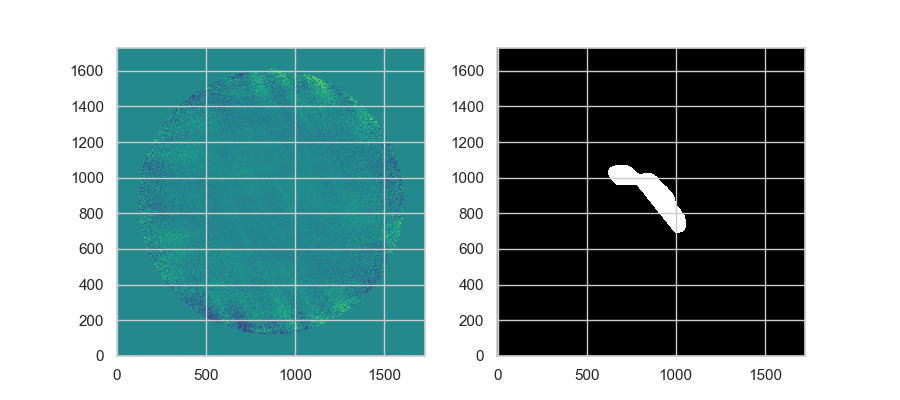

<IPython.core.display.Javascript object>


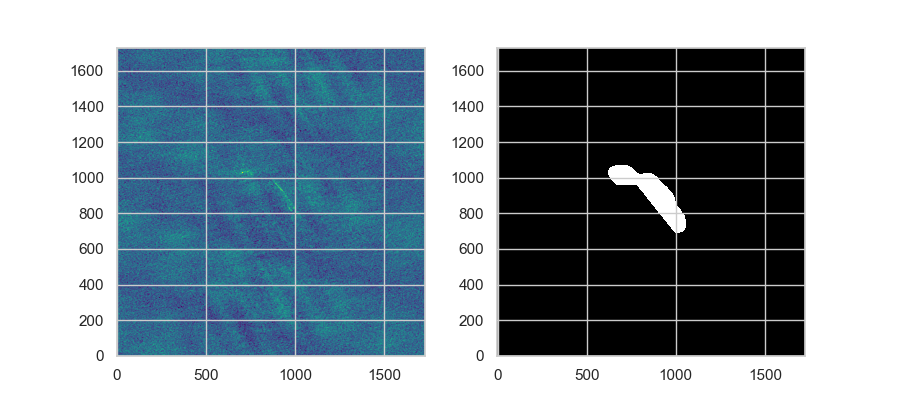

In [96]:
def load_hst(header):
    h = fits.getheader(header)
    mask,_ = reproject_interp('a521_target_mask.fits',h)
    mask = mask.astype('float')
    mask[np.where(np.isnan(mask))] = 0
    return mask


mask_a521 = load_hst('../Data/Moments/a521_mom0.fits')

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(N1_a521_im,origin='lower',cmap='viridis')
ax[1].imshow(mask_a521,origin='lower',vmax=0.1,cmap='Greys_r')

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(N2_a521_im,origin='lower',cmap='viridis')
ax[1].imshow(mask_a521,origin='lower',vmax=0.1,cmap='Greys_r')

<IPython.core.display.Javascript object>


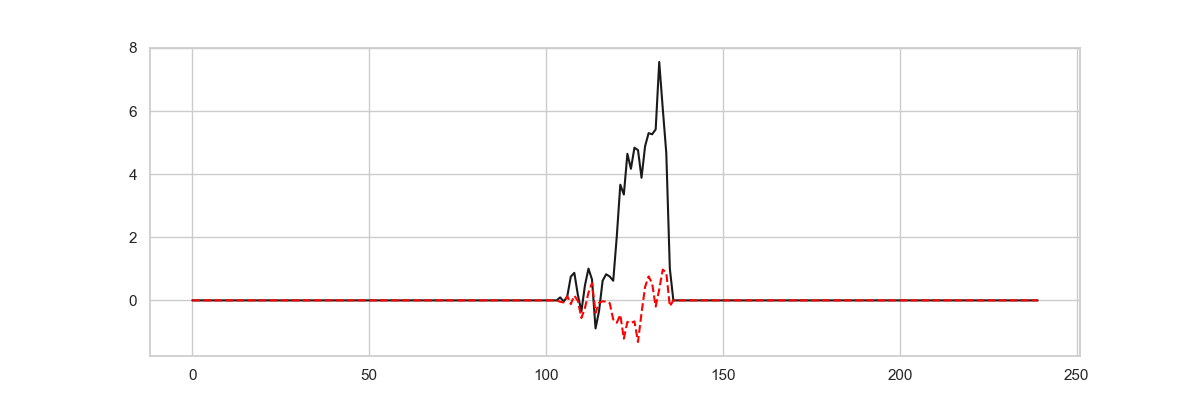

<IPython.core.display.Javascript object>


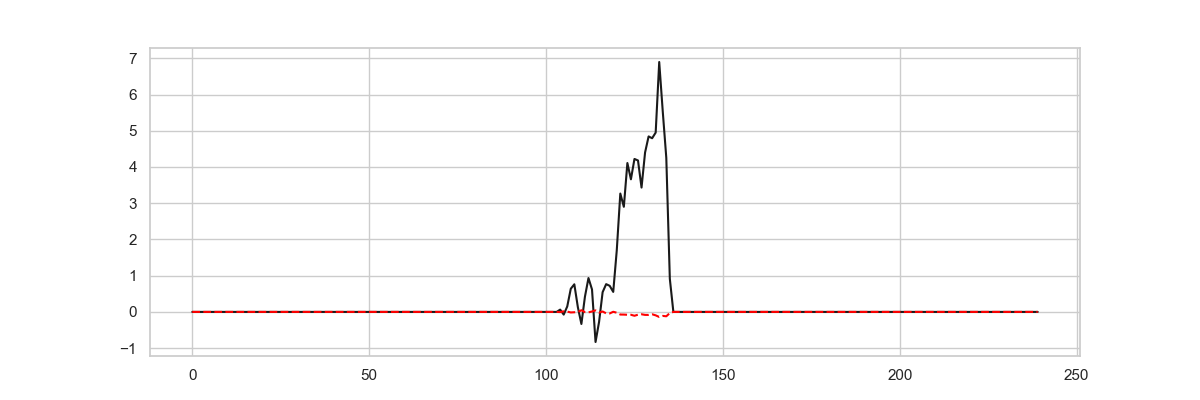

<IPython.core.display.Javascript object>


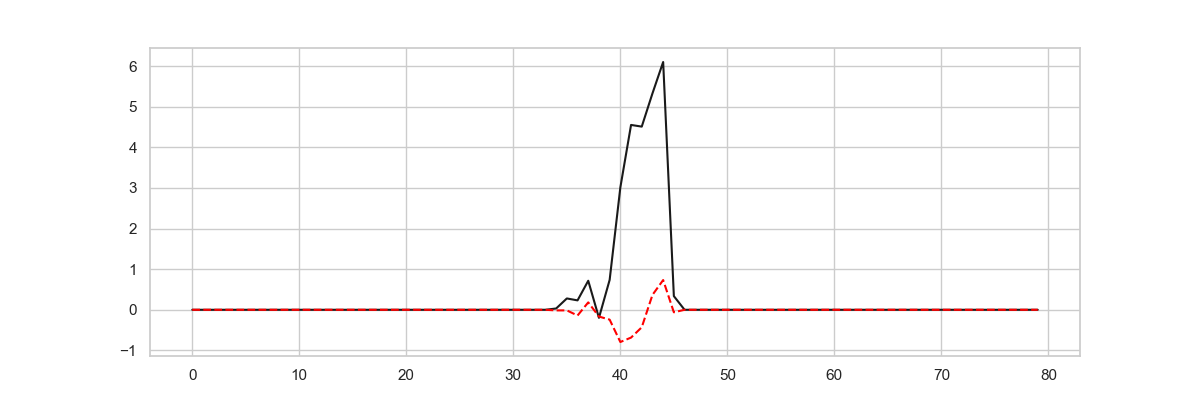

<IPython.core.display.Javascript object>


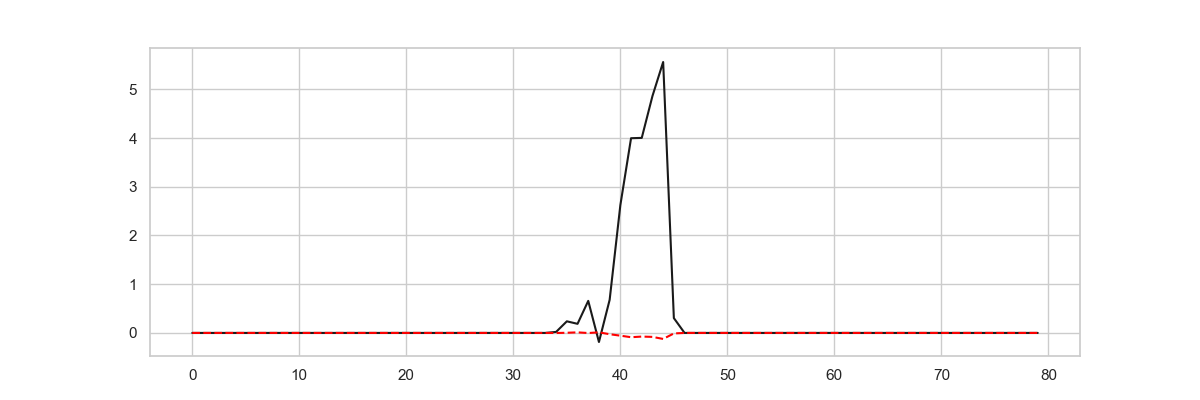

In [101]:
sp_a521_N1  = extract_spectrum('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits',mask_a521)
sp_a521_N2  = extract_spectrum('../Data/Cubes/A521_CO43.fits',mask_a521)

sp_a521_R1  = extract_spectrum('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits',mask_a521)
sp_a521_R2  = extract_spectrum('../Data/Cubes/A521_CO43_rebin.fits',mask_a521)

**This looks very weird**
Extract only on a small region 

<IPython.core.display.Javascript object>


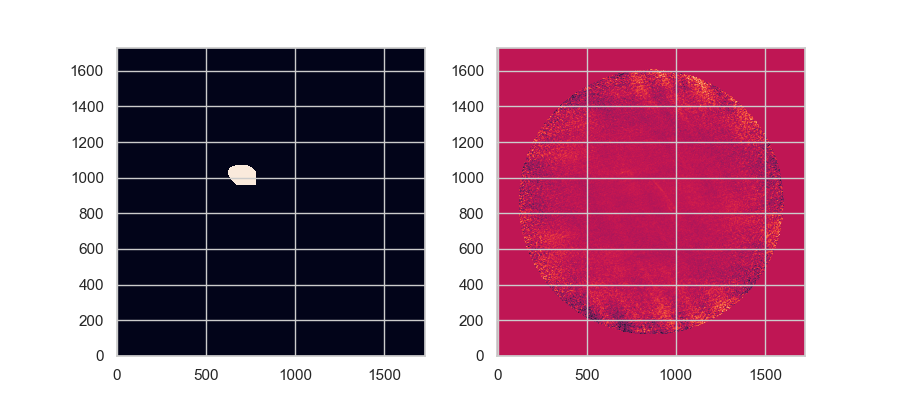

In [98]:
new_mask = mask_a521.copy()
new_mask[:,780:] = 0

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(new_mask,origin='lower')
ax[1].imshow(R1_a521_im,origin='lower')

Extract spectra from empty region

<IPython.core.display.Javascript object>


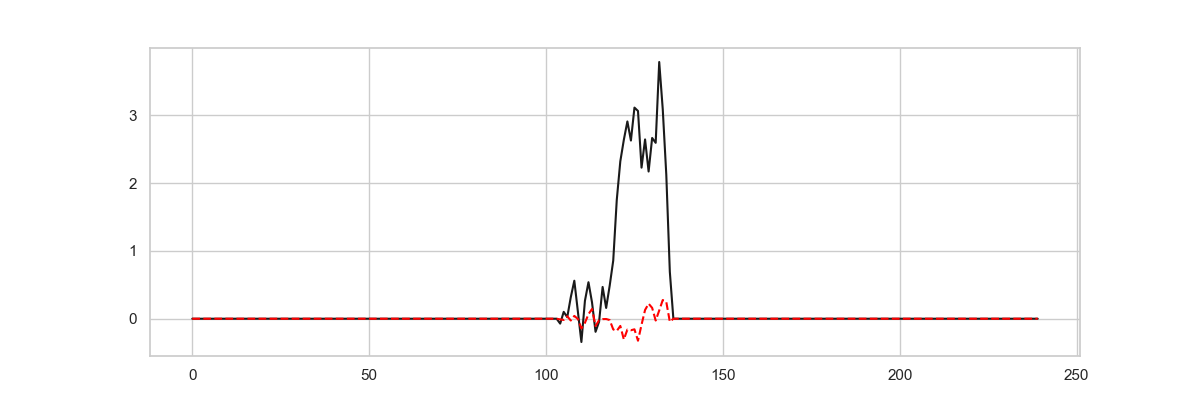

In [100]:
test_sp_a521 = extract_spectrum('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits',new_mask)

<IPython.core.display.Javascript object>


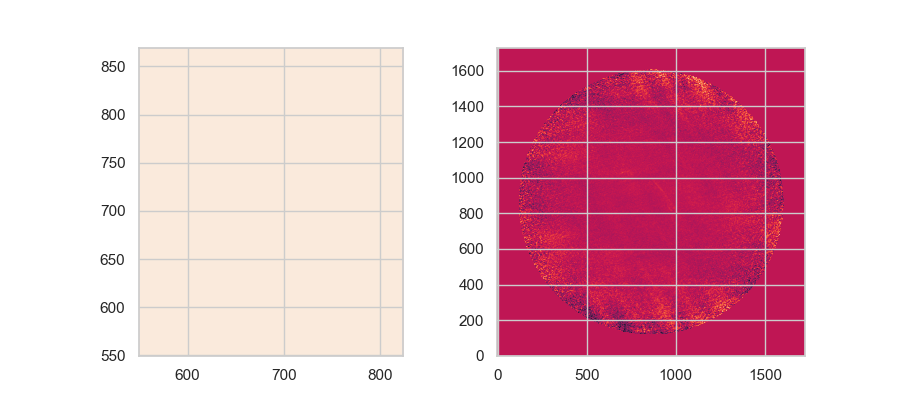

In [121]:
empty_mask = 1-mask_a521

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(empty_mask,origin='lower')
ax[1].imshow(R1_a521_im,origin='lower')

<IPython.core.display.Javascript object>


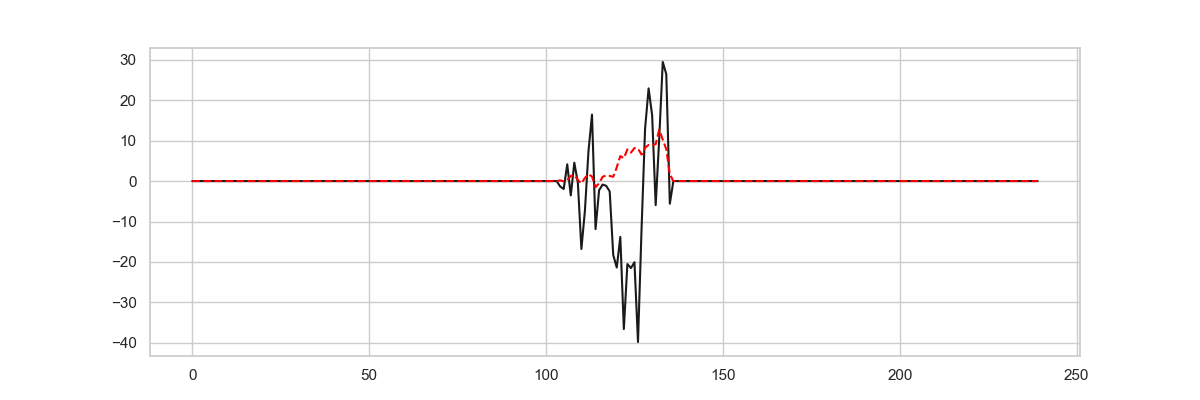

In [123]:
noise_sp_a521 = extract_spectrum('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits',empty_mask)

In [130]:
mean,_,std = sigma_clipped_stats(noise_sp_a521[100:135])
print(std)

15.606764729841549


Make proper narrow bands

In [102]:
N1_a521_im = make_image('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits',{'start':105,'end':135})
N2_a521_im = make_image('../Data/Cubes/A521_CO43.fits',{'start':105,'end':135})

R1_a521_im = make_image('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits',{'start':34,'end':46})
R2_a521_im = make_image('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits',{'start':34,'end':46})

Calculate flux

In [132]:
integrate_spectra(sp_a521_N1,110,140,ch_N1_a521,'../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits',std=15.6)
integrate_spectra(sp_a521_N2,110,140,ch_N2_a521,'../Data/Cubes/A521_CO43.fits')
integrate_spectra(sp_a521_R1,34,46,ch_R1_a521,'../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits')
integrate_spectra(sp_a521_R2,34,46,ch_R2_a521,'../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits')

Flux 774.3825 (Jy/beam)
Flux 17.7756 (Jy)
Error 10.7427 (Jy)
Flux 694.3301 (Jy/beam)
Flux 15.9380 (Jy)
Error 0.0000 (Jy)
Flux 794.8237 (Jy/beam)
Flux 18.2448 (Jy)
Error 0.0000 (Jy)
Flux 711.6053 (Jy/beam)
Flux 16.3346 (Jy)
Error 0.0000 (Jy)


Calculate noise

In [109]:
box_a521 = {'x1':600,'x2':900,'y1':500,'y2':700}

In [110]:
noise('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor.fits',box_a521)
noise('../Data/Cubes/A521_CO43.fits',box_a521)

noise('../Data/Cubes/latest_cubes/A521_CO_4-3_pbcor_rebin.fits',box_a521)
noise('../Data/Cubes/A521_CO43_rebin.fits',box_a521)

Sigma clip stats (mean, median, std)  (2.4253936e-11, 0.0, 1.0259376e-07)
RMS 0.000164
Sigma clip stats (mean, median, std)  (1.9348294e-11, 0.0, 6.805423e-08)
RMS 0.000117
Sigma clip stats (mean, median, std)  (4.1498766e-12, 0.0, 1.928762e-07)
RMS 0.000100
Sigma clip stats (mean, median, std)  (-2.4815388e-11, 0.0, 1.2759382e-07)
RMS 0.000071


Use the A521_CO_4-3_pbcor.fits, because I think the others do not have the primary beam correction

## Snake

Cubes available

    Native binning
    N: ../Data/Cubes/snake_cube_v5.image.pbcor.fits 
    
    Rebined
    R: ../Data/Cubes/snake_rebin.fits

In [133]:
ch_N_snake = channel_width('../Data/Cubes/snake_cube_v5.image.pbcor.fits')
ch_R_snake = channel_width('../Data/Cubes/snake_rebin.fits')

10.301829601193552 km / s
30.905488803580656 km / s


In [134]:
N_snake_im = make_image('../Data/Cubes/snake_cube_v5.image.pbcor.fits')

R_snake_im = make_image('../Data/Cubes/snake_rebin.fits')

Load mask

<IPython.core.display.Javascript object>


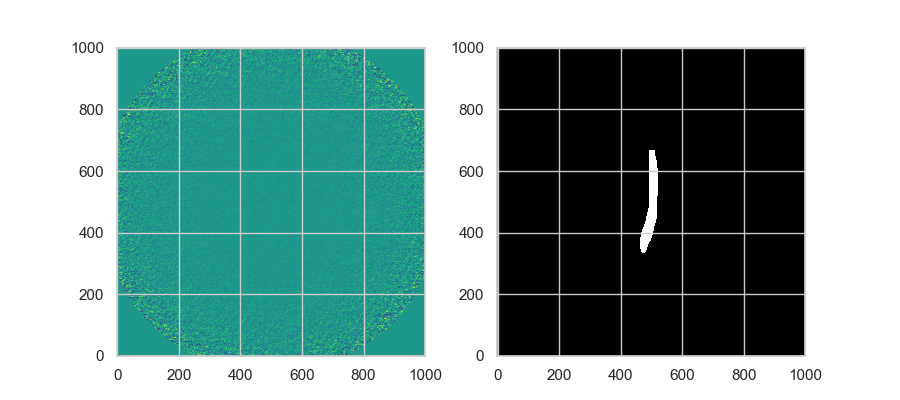

In [135]:
def load_hst(header):
    h = fits.getheader(header)
    mask,_ = reproject_interp('snake_target_mask.fits',h)
    mask = mask.astype('float')
    mask[np.where(np.isnan(mask))] = 0
    return mask

mask_snake = load_hst('../Data/Moments/snake_mom0.fits')

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(N_snake_im,origin='lower',cmap='viridis')
ax[1].imshow(mask_snake,origin='lower',vmax=0.1,cmap='Greys_r')

<IPython.core.display.Javascript object>


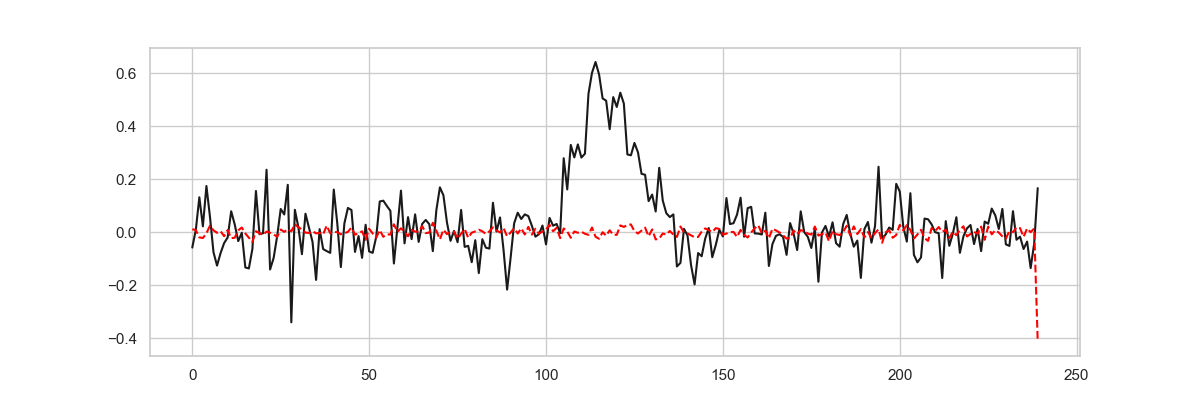

<IPython.core.display.Javascript object>


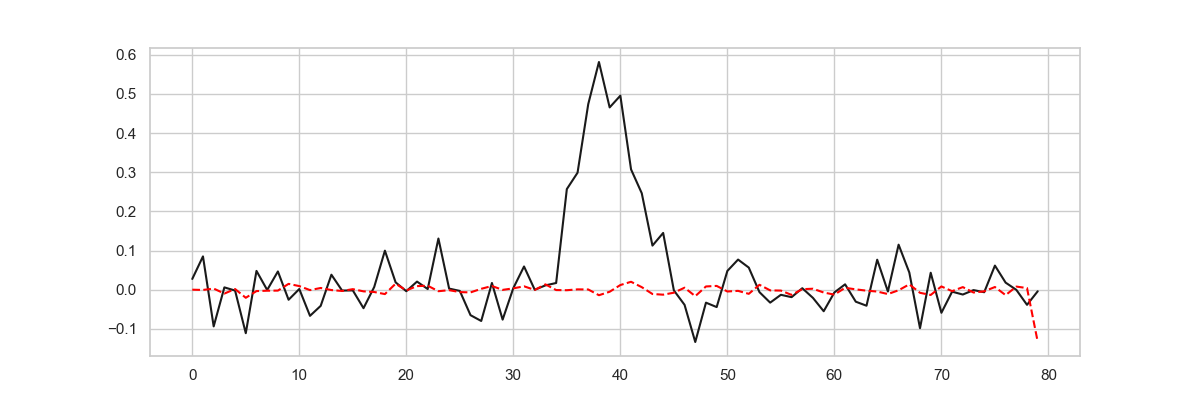

In [136]:
sp_snake_N  = extract_spectrum('../Data/Cubes/snake_cube_v5.image.pbcor.fits',mask_snake)
sp_snake_R  = extract_spectrum('../Data/Cubes/snake_rebin.fits',mask_snake)

Make narrow bands

In [137]:
N_snake_im = make_image('../Data/Cubes/snake_cube_v5.image.pbcor.fits',{'start':100,'end':140})

R_snake_im = make_image('../Data/Cubes/snake_rebin.fits',{'start':30,'end':50})

## Measure flux

In [138]:
print('Spectra')
integrate_spectra(sp_snake_N,100,140,ch_N_snake,'../Data/Cubes/snake_cube_v5.image.pbcor.fits')
integrate_spectra(sp_snake_R,30,50,ch_R_snake,'../Data/Cubes/snake_rebin.fits')

Spectra
Flux 104.0982 (Jy/beam)
Flux 3.7298 (Jy)
Error 0.1156 (Jy)
Flux 99.7045 (Jy/beam)
Flux 3.5724 (Jy)
Error 0.0358 (Jy)


Measure Noise

In [141]:
box_snake = {'x1':300,'x2':400,'y1':300,'y2':400}

In [142]:
noise('../Data/Cubes/snake_cube_v5.image.pbcor.fits',box_snake)
noise('../Data/Cubes/snake_rebin.fits',box_snake)

Sigma clip stats (mean, median, std)  (-1.6504534e-07, -1.4682331e-07, 0.00047559958)
RMS 0.000670
Sigma clip stats (mean, median, std)  (-2.6739613e-07, -2.310165e-07, 0.00028193032)
RMS 0.000391
